# 数据预处理

In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization,concatenate, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt

with h5py.File('./DB3/DB3_S1_image.h5', 'r') as f:
    imageData = f['imageData'][:]
    imageData = imageData * 2000
    imageLabel = f['imageLabel'][:]

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data  = imageData[index, :, :]
label = imageLabel[index]

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# 对数据升维 标签one-hot
data = np.expand_dims(data, axis=3)
label = convert_to_one_hot(label, 16).T

# 划分数据集
N = data.shape[0]
num_train = round(N * 0.8)
X_train = data[0:num_train, :, :]
Y_train = label[0:num_train, :]
X_test = data[num_train:N, :, :]
Y_test = label[num_train:N, :]

print('X_train shape:', str(X_train.shape))
print('Y_train shape:', str(Y_train.shape))
print('X_test shape:', str(X_test.shape))
print('Y_test shape:', str(Y_test.shape))

X_train shape: (3827, 200, 6, 1)
Y_train shape: (3827, 16)
X_test shape: (957, 200, 6, 1)
Y_test shape: (957, 16)


In [2]:
# 写一个LossHistory类 保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc='upper right')
        plt.show()

# 建立模型

In [3]:
def CNN(input_shape=(200, 6, 1), classes=16): 
    X_input = Input(input_shape)
    X = Conv2D(filters=32, kernel_size=(20, 3), strides=(1, 1), activation='relu', padding='same')(X_input)
    X = MaxPooling2D((20, 1))(X)
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(X)
    X = MaxPooling2D((2, 1))(X)
    X = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid')(X)
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = Dense(128,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax')(X)
    model = Model(inputs=X_input, outputs=X)
    return model

model = CNN()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 6, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 6, 32)        1952      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 6, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 6, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0     

# 训练原始数据

In [4]:
import time

start = time.time()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = LossHistory() # 创建一个history实例
model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64, callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print('Train Loss =', str(preds_train[0]))
print('Train Accuracy =', str(preds_train[1]))

preds_test = model.evaluate(X_test, Y_test)
print('Test Loss =', str(preds_test[0]))
print('Test Accuracy =', str(preds_test[1]))

end = time.time()
print('time:', end - start)

Epoch 1/100
60/60 [==============================] - 5s 87ms/step - loss: 2.3006 - acc: 0.2153 - val_loss: 1.5512 - val_acc: 0.4284
Epoch 2/100
60/60 [==============================] - 6s 95ms/step - loss: 1.4720 - acc: 0.4690 - val_loss: 0.9528 - val_acc: 0.7064
Epoch 3/100
60/60 [==============================] - 4s 71ms/step - loss: 1.0022 - acc: 0.6433 - val_loss: 0.6300 - val_acc: 0.7795
Epoch 4/100
60/60 [==============================] - 4s 70ms/step - loss: 0.7581 - acc: 0.7309 - val_loss: 0.5075 - val_acc: 0.8182
Epoch 5/100
60/60 [==============================] - 4s 69ms/step - loss: 0.6347 - acc: 0.7771 - val_loss: 0.4326 - val_acc: 0.8464
Epoch 6/100
60/60 [==============================] - 5s 90ms/step - loss: 0.5679 - acc: 0.7972 - val_loss: 0.3996 - val_acc: 0.8370
Epoch 7/100
60/60 [==============================] - 6s 103ms/step - loss: 0.5009 - acc: 0.8181 - val_loss: 0.3681 - val_acc: 0.8621
Epoch 8/100
60/60 [==============================] - 8s 129ms/step - loss: 

60/60 [==============================] - 6s 97ms/step - loss: 0.1066 - acc: 0.9564 - val_loss: 0.2440 - val_acc: 0.9091
Epoch 63/100
60/60 [==============================] - 6s 96ms/step - loss: 0.1107 - acc: 0.9535 - val_loss: 0.2782 - val_acc: 0.9018
Epoch 64/100
60/60 [==============================] - 5s 89ms/step - loss: 0.1220 - acc: 0.9488 - val_loss: 0.2820 - val_acc: 0.9007
Epoch 65/100
60/60 [==============================] - 6s 92ms/step - loss: 0.1214 - acc: 0.9475 - val_loss: 0.2753 - val_acc: 0.9039
Epoch 66/100
60/60 [==============================] - 6s 94ms/step - loss: 0.1141 - acc: 0.9530 - val_loss: 0.2371 - val_acc: 0.9122
Epoch 67/100
60/60 [==============================] - 6s 99ms/step - loss: 0.0931 - acc: 0.9553 - val_loss: 0.2349 - val_acc: 0.9216
Epoch 68/100
60/60 [==============================] - 6s 105ms/step - loss: 0.0946 - acc: 0.9634 - val_loss: 0.2288 - val_acc: 0.9195
Epoch 69/100
60/60 [==============================] - 6s 97ms/step - loss: 0.1004

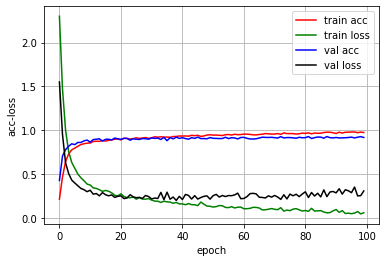

In [5]:
history.loss_plot('epoch')